<a href="https://colab.research.google.com/github/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF/blob/main/Endnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blind Unmixing

Original implementation found at https://github.com/burknipalsson/hu_autoencoders/blob/main/Method_Endnet.ipynb


## *ENDNET: SPARSE AUTOENCODER NETWORK FOR ENDMEMBER EXTRACTION AND HYPERSPECTRAL UNMIXING*
S. Ozkan, B. Kaya and G. B. Akar, "EndNet: Sparse AutoEncoder Network for Endmember Extraction and Hyperspectral Unmixing," in IEEE Transactions on Geoscience and Remote Sensing, vol. 57, no. 1, pp. 482-496, Jan. 2019, doi: 10.1109/TGRS.2018.2856929.

### Loss is given by 
$$\mathcal{L} = \frac{\lambda_0}{2}\|\mathbf{x}-\hat{\mathbf{x}}\|_2^2-\lambda_1 D_\text{KL}(1.0||C(\mathbf{x},\hat{\mathbf{x}}))+\lambda_2\|\mathbf{z}\|_1+\lambda_3\|\mathbf{W^{(e)}}\|_2+\lambda_4\|\mathbf{W}^{(d)}\|_2+\lambda_5\|\mathbf{\rho}\|_2$$
where
$$C(x^{(i)},x^{(j)})=1.0-\frac{SAD(x^{(i)},x^{(j)})}{\pi}$$

### Imports

In [1]:
!git clone https://github.com/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF.git

fatal: destination path 'Unmixing_Tutorial_IEEE_IADF' already exists and is not an empty directory.


In [2]:
!pip install munkres
!pip install tensorflow==2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import initializers, constraints, layers, activations, regularizers
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import tensor_shape
from scipy import io as sio
import scipy as sp
import scipy.linalg as splin
import os
import numpy as np
from numpy.linalg import inv
import warnings
import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
from Unmixing_Tutorial_IEEE_IADF.utils.data import HSI
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import MeanSquareError as MSE
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import aRMSE as RMSE
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import SADDegrees as SADMetric 
from Unmixing_Tutorial_IEEE_IADF.utils.aligners import MunkresAbundancesAligner as Aligner

### Use CPU

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Endmembers extractor - VCA

---

In [6]:
def estimate_snr(Y, r_m, x):

    # L number of bands (channels), N number of pixels
    [L, N] = Y.shape
    [p, N] = x.shape           # p number of endmembers (reduced dimension)

    P_y = sp.sum(Y**2)/float(N)
    P_x = sp.sum(x**2)/float(N) + sp.sum(r_m**2)
    snr_est = 10*sp.log10((P_x - p/L*P_y)/(P_y - P_x))

    return snr_est

def vca(Y, R, verbose=True, snr_input=0):
    # Vertex Component Analysis
    #
    # Ae, indice, Yp = vca(Y,R,verbose = True,snr_input = 0)
    #
    # ------- Input variables -------------
    #  Y - matrix with dimensions L(channels) x N(pixels)
    #      each pixel is a linear mixture of R endmembers
    #      signatures Y = M x s, where s = gamma x alfa
    #      gamma is a illumination perturbation factor and
    #      alfa are the abundance fractions of each endmember.
    #  R - positive integer number of endmembers in the scene
    #
    # ------- Output variables -----------
    # Ae     - estimated mixing matrix (endmembers signatures)
    # indice - pixels that were chosen to be the most pure
    # Yp     - Data matrix Y projected.
    #
    # ------- Optional parameters---------
    # snr_input - (float) signal to noise ratio (dB)
    # v         - [True | False]
    # ------------------------------------
    #
    # Author: Adrien Lagrange (adrien.lagrange@enseeiht.fr)
    # This code is a translation of a matlab code provided by
    # Jose Nascimento (zen@isel.pt) and Jose Bioucas Dias (bioucas@lx.it.pt)
    # available at http://www.lx.it.pt/~bioucas/code.htm under a non-specified Copyright (c)
    # Translation of last version at 22-February-2018 (Matlab version 2.1 (7-May-2004))
    #
    # more details on:
    # Jose M. P. Nascimento and Jose M. B. Dias
    # "Vertex Component Analysis: A Fast Algorithm to Unmix Hyperspectral Data"
    # submited to IEEE Trans. Geosci. Remote Sensing, vol. .., no. .., pp. .-., 2004
    #
    #

    #############################################
    # Initializations
    #############################################
    if len(Y.shape) != 2:
        sys.exit(
            'Input data must be of size L (number of bands i.e. channels) by N (number of pixels)')

    [L, N] = Y.shape   # L number of bands (channels), N number of pixels

    R = int(R)
    if (R < 0 or R > L):
        sys.exit('ENDMEMBER parameter must be integer between 1 and L')

    #############################################
    # SNR Estimates
    #############################################

    if snr_input == 0:
        y_m = sp.mean(Y, axis=1, keepdims=True)
        Y_o = Y - y_m           # data with zero-mean
        # computes the R-projection matrix
        Ud = splin.svd(sp.dot(Y_o, Y_o.T)/float(N))[0][:, :R]
        # project the zero-mean data onto p-subspace
        x_p = sp.dot(Ud.T, Y_o)

        SNR = estimate_snr(Y, y_m, x_p)

        if verbose:
            print("SNR estimated = {}[dB]".format(SNR))
    else:
        SNR = snr_input
        if verbose:
            print("input SNR = {}[dB]\n".format(SNR))

    SNR_th = 15 + 10*sp.log10(R)

    #############################################
    # Choosing Projective Projection or
    #          projection to p-1 subspace
    #############################################

    if SNR < SNR_th:
        if verbose:
            print("... Select proj. to R-1")

            d = R-1
            if snr_input == 0:  # it means that the projection is already computed
                Ud = Ud[:, :d]
            else:
                y_m = sp.mean(Y, axis=1, keepdims=True)
                Y_o = Y - y_m  # data with zero-mean

                # computes the p-projection matrix
                Ud = splin.svd(sp.dot(Y_o, Y_o.T)/float(N))[0][:, :d]
                # project thezeros mean data onto p-subspace
                x_p = sp.dot(Ud.T, Y_o)

            Yp = sp.dot(Ud, x_p[:d, :]) + y_m      # again in dimension L

            x = x_p[:d, :]  # x_p =  Ud.T * Y_o is on a R-dim subspace
            c = sp.amax(sp.sum(x**2, axis=0))**0.5
            y = sp.vstack((x, c*sp.ones((1, N))))
    else:
        if verbose:
            print("... Select the projective proj.")

        d = R
        # computes the p-projection matrix
        Ud = splin.svd(sp.dot(Y, Y.T)/float(N))[0][:, :d]

        x_p = sp.dot(Ud.T, Y)
        # again in dimension L (note that x_p has no null mean)
        Yp = sp.dot(Ud, x_p[:d, :])

        x = sp.dot(Ud.T, Y)
        u = sp.mean(x, axis=1, keepdims=True)  # equivalent to  u = Ud.T * r_m
        y = x / sp.dot(u.T, x)

    #############################################
    # VCA algorithm
    #############################################

    indice = sp.zeros((R), dtype=int)
    A = sp.zeros((R, R))
    A[-1, 0] = 1

    for i in range(R):
        w = sp.random.rand(R, 1)
        f = w - sp.dot(A, sp.dot(splin.pinv(A), w))
        f = f / splin.norm(f)

        v = sp.dot(f.T, y)

        indice[i] = sp.argmax(sp.absolute(v))
        A[:, i] = y[:, indice[i]]        # same as x(:,indice(i))

    Ae = Yp[:, indice]

    return Ae, indice, Yp

## Method SAD

In [7]:
def SAD(y_true, y_pred):
    A = -tf.keras.losses.cosine_similarity(y_true,y_pred)
    sad = tf.math.acos(A)
    return sad

## Method C
method that implements 
$$C(x^{(i)},x^{(j)})=1.0-\frac{SAD(x^{(i)},x^{(j)})}{\pi}$$

In [8]:
def C(x,y):
    val=1.0-SAD(x,y)/np.pi
    return val

In [9]:
class Cdot(object):
    def __init__(self,vec):
        self.vec=vec
        
    def dot(self, x):
        val=1.0-SAD(self.vec,x)/np.pi
        return val

## Fidelity terms
The fidelity terms of the loss
$$\mathcal{L} = \frac{\lambda_0}{2}\|\mathbf{x}-\hat{\mathbf{x}}\|_2^2-\lambda_1 D_\text{KL}(1.0||C(\mathbf{x},\hat{\mathbf{x}}))$$

In [10]:
class Endnet_loss(object):
    def __init__(self, batch_size,lambda0,lambda1):
        self.lambda0 = lambda0
        self.lambda1 = lambda1
        self.b = batch_size
    def loss(self, y_true, y_pred):
        MSE = tf.keras.losses.mse(y_true,y_pred) 
        c=C(y_true,y_pred)
        KL_Divergence = -tf.math.log(c)
        loss = self.lambda0/2.0*MSE+self.lambda1*KL_Divergence
        return loss

## Class SumToOne
Custom layer that enforces the ASC. Also performs regularizations l1
$$\lambda_2\|\mathbf{z}\|_1$$

In [11]:
class SumToOne(layers.Layer):
    def __init__(self, params, **kwargs):
        super(SumToOne, self).__init__(**kwargs)
        self.params = params
    
    def mask_all_but_top_k(self,X, k):
        n = X.shape[1]
        top_k_indices = tf.math.top_k(X, k).indices
        mask = tf.reduce_sum(tf.one_hot(top_k_indices, n), axis=1)
        return mask * X
    
    def l1_regularization(self,x):
        l1 = regularizers.l1(1.0)(x)
        return self.params['lambda2'] * l1
        
    def call(self, x):
        self.add_loss(self.l1_regularization(x))
        x = self.mask_all_but_top_k(x,2)
        x = tf.abs(x)/(tf.reduce_sum(x, axis=-1, keepdims=True)+K.epsilon())
        return x

## Class MaskedNoise
Adds noise to the layer masked


In [12]:
class MaskedNoise(layers.Layer):
    def __init__(self, params, **kwargs):
        super(MaskedNoise, self).__init__(**kwargs)
        self.std = params['noise']
    
        
    def call(self, x, training=None):
        if training:
            mask = tf.nn.dropout(tf.ones_like(x),0.4)
            noise = layers.GaussianNoise(self.std)(tf.zeros_like(x))
            return x+mask*noise
        else:
            return x
        
        



## Class Spectral_BN
Performs batch normalization with no scaling
$$BN(\bf{h})=\frac{\bf{h}-\bf{\mu}}{\sqrt{\bf{\sigma^2}+\epsilon}}+\bf{\rho}$$

In [13]:
class Spectral_BN(layers.Layer):
    def __init__(self, params, **kwargs):
        super(Spectral_BN, self).__init__(**kwargs)
        self.num_outputs = params['num_endmembers']
        self.params = params
    
    def l2_regularization(self,x):
        l2 = tf.reduce_sum(tf.square(x))
        return self.params['lambda5'] * l2
    
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.p = self.add_weight(shape=(input_dim,),
                                 initializer="zeros",
                                 trainable=True)
    def call(self, x, training=None):
        if training is not None:
            mu = tf.reduce_mean(x,axis=0)
            sigma = tf.sqrt(tf.math.reduce_variance(x,axis=0)+K.epsilon())
            y = (x-mu)/sigma+self.p
            self.add_loss(self.l2_regularization(self.p))
            return y
        else:
            return x

In [14]:
class SparseReLU(tf.keras.layers.Layer):
    def __init__(self):
        super(SparseReLU, self).__init__()
    def build(self, input_shape):
        self.alpha = self.add_weight(shape=input_shape[1:],initializer=tf.keras.initializers.Zeros(),
        trainable=True, constraint=tf.keras.constraints.non_neg())
        super(SparseReLU, self).build(input_shape)
    def call(self, x):
        return tf.keras.backend.relu(x - self.alpha)

## Class Custom_layer_transform
Performs matrix vector multiplication using custom innner product

In [15]:
class Custom_layer_transform(object):
    def __init__(self,W:tf.Tensor):
        self.W = tf.transpose(W)
    def custom_matvec_prod(self, a:tf.Tensor):
        cdot = Cdot(a)
        return tf.map_fn(cdot.dot,self.W)
    
    def transform(self,Batch:tf.Tensor):
        return tf.map_fn(self.custom_matvec_prod, Batch)
        #return tf.transpose(tf.map_fn(self.custom_matvec_prod, Batch),(0,2,1))
    

## Class SAD_Layer
This is a dense layer that transforms its inputs using a custom matrix vector product that uses normalized SAD as the inner product.

In [16]:
class SAD_Layer(tf.keras.layers.Layer):
    def __init__(
        self,
        units,
        activation=None,
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        **kwargs
    ):
        if "input_shape" not in kwargs and "input_dim" in kwargs:
            kwargs["input_shape"] = (kwargs.pop("input_dim"),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = tf.keras.regularizers.get(bias_regularizer)
        self.activity_regularizer = tf.keras.regularizers.get(activity_regularizer)
        self.kernel_constraint = tf.keras.constraints.get(kernel_constraint)
        self.bias_constraint = tf.keras.constraints.get(bias_constraint)
        self.input_spec = tf.keras.layers.InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(
            shape=(input_dim, self.units),
            initializer=self.kernel_initializer,
            name="kernel",
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            )
        if self.use_bias:
                self.bias = self.add_weight(
                    shape=(self.units,),
                    initializer=self.bias_initializer,
                    name="bias",
                    regularizer=self.bias_regularizer,
                    constraint=self.bias_constraint,
                    )
        else:
            self.bias = None
        self.input_spec = tf.keras.layers.InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        print(self.kernel.get_shape())
        print(inputs.get_shape())
        custom_transform = Custom_layer_transform(self.kernel)
        output = custom_transform.transform(inputs)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format="channels_last")
        if self.activation is not None:
            output = self.activation(output)
        return output

## Class Autoencoder
Wrapper class for the autoencoder model and associcated utility functions

In [17]:
class Autoencoder(object):
    def __init__(self, params,W=None):
        #self.data = params["data"].array()
        self.data = params["data"]
        self.params = params
        self.masked_noise = MaskedNoise(params)
        self.decoder = layers.Dense(
            units=self.params["n_bands"],
            kernel_regularizer=regularizers.l2(self.params['lambda4']),
            activation='linear',
            name="output",
            kernel_constraint=constraints.non_neg(),
            use_bias=False)
            
        self.hidden = SAD_Layer(
            units=self.params["num_endmembers"],
            activation='linear',
            kernel_regularizer=regularizers.l2(self.params['lambda3']),
            name='hidden',
            use_bias=False
        )

        #self.spectral_bn = Spectral_BN(params)# BatchNormalization(scale=False)
        self.sparse_relu = SparseReLU()
        self.asc_layer = SumToOne(self.params, name='abundances')
        self.model = self.create_model()
        self.model.compile(optimizer=self.params["optimizer"], loss=self.params["loss"])
        #self.initalize_encoder_and_decoder(W)

    def initalize_encoder_and_decoder(self,W):
        if W is None: return
        self.model.get_layer('output').set_weights([W.T])
        self.model.get_layer('hidden').set_weights([W])
        return
        
        
    def create_model(self):
        input_features = layers.Input(shape=(self.params["n_bands"],))
        code = self.masked_noise(input_features)
        code = self.hidden(code)
        code = layers.BatchNormalization(scale=False)(code)
        #code = self.spectral_bn(code)
        code = layers.Dropout(self.params['p'])(code)
        code = tf.keras.activations.relu(code)
        abunds = self.asc_layer(code)
        output = self.decoder(abunds)

        return tf.keras.Model(inputs=input_features, outputs=output)
    
    def fix_decoder(self):
        for l in self.model.layers:
            l.trainable = True
        self.model.layers[-1].trainable = False
        self.decoder.trainable = False
        self.model.compile(optimizer=self.params["optimizer"], loss=self.params["loss"])

    def fix_encoder(self):
        for l in self.model.layers:
            l.trainable = True
        self.model.get_layer('hidden').trainable = False
        self.hidden.trainable = False
        self.model.compile(optimizer=self.params["optimizer"], loss=self.params["loss"])

        
    
    def fit(self,data,n):
        #plot_callback = PlotWhileTraining(n,self.params['data'])
        return self.model.fit(
            x=data,
            y=data,
            batch_size=self.params["batch_size"],
            epochs=self.params["epochs"],
        )
    
    def train_alternating(self,data,epochs):
        for epoch in range(epochs):
            self.fix_decoder()
            self.model.fit(x=data, y=data,
                batch_size=self.params["batch_size"],
                epochs=2)
            self.fix_encoder()
            self.model.fit(x=data, y=data,
                batch_size=self.params["batch_size"],
                epochs=1)
            #if epoch % 3 == 0:
            #    endmembers = self.get_endmembers()
            #    abundances = self.get_abundances()
            #    plotEndmembersAndGT(endmembers,self.params['data'].gt)
            #    plotAbundancesSimple(abundances,'abunds')
        

    def get_endmembers(self):
        #one_hot = tf.one_hot(tf.range(0,self.params['num_endmembers']),self.params['num_endmembers'])
        return self.model.layers[len(self.model.layers) - 1].get_weights()[0]

    def get_abundances(self):
        intermediate_layer_model = tf.keras.Model(
            inputs=self.model.input, outputs=self.model.get_layer("abundances").output
        )
        abundances = intermediate_layer_model.predict(self.data)
        #abundances = np.reshape(abundances,[self.params['data'].cols,self.params['data'].rows,self.params['num_endmembers']])
        
        return abundances

## Set Hyperparameters and load data

Matlab data keys: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'])
HSI => TinyAPEX
---------------------
285 bands,
111 lines, 122 samples, (13542 pixels),
4 endmembers (['#0', '#1', '#2', '#3'])
GlobalMinValue: 0.0, GlobalMaxValue: 1.0



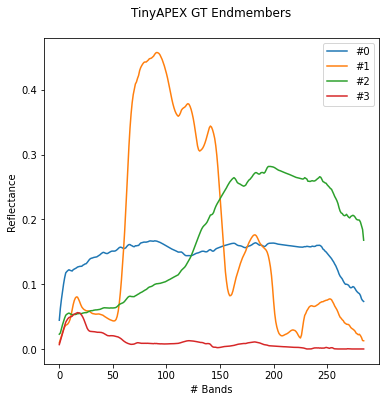

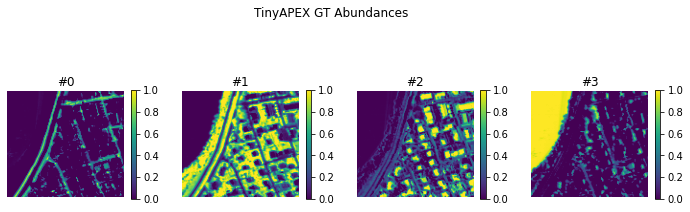

In [18]:
hsi = HSI("TinyAPEX.mat")
print(hsi)
hsi.plot_endmembers()
hsi.plot_abundances()

In [22]:
# Hyperparameters
num_endmembers = hsi.p
num_spectra = 4000
batch_size = 64
learning_rate = 0.001
epochs = 40
#epochs = 5
lambda0 = 0.01
lambda1 = 50.0
lambda2 = 0.0
lambda3 = 1e-5
lambda4 = 1e-5
lambda5 = 1e-3
p = 0.1
noise_std = 0.3
opt = tf.optimizers.Adam(learning_rate=learning_rate,beta_1=0.7)

data, GT, _ = hsi()

# Reshape data
data = data.T

# Hyperparameter dictionary
params = {
    "lambda0":lambda0,
    "lambda1":lambda1,
    "lambda2":lambda2,
    "lambda3":lambda3,
    "lambda4":lambda4,
    "lambda5":lambda5,
    "p":p,
    "num_endmembers": num_endmembers,
    "batch_size": batch_size,
    "num_spectra": num_spectra,
    "data": data,
    "epochs": epochs,
    "n_bands": hsi.L,
    #"GT": hsi.gt,
    "GT": GT,
    "lr": learning_rate,
    "optimizer": opt,
    "noise":noise_std,
    "loss":Endnet_loss(batch_size,lambda0,lambda1).loss
}

plot_every = 0 #Plot endmembers and abundance maps every x epochs. Set to 0 when running experiments. 

training_data = data[
    np.random.randint(0, data.shape[0], num_spectra), :
]


(285, 13542)
(13542, 285)


## Train Autoencoder

In [23]:
init = vca(data.T,params['num_endmembers'])[0]
autoencoder = Autoencoder(params,init)
autoencoder.fit(training_data,plot_every)
endmembers = autoencoder.get_endmembers()
abundances = autoencoder.get_abundances()

SNR estimated = 24.20089955983165[dB]
... Select the projective proj.
(285, 4)
(None, 285)
Train on 4000 samples
Epoch 1/5
4000/4000 [==============================] - 12s 3ms/sample - loss: 15.1668
Epoch 2/5
4000/4000 [==============================] - 13s 3ms/sample - loss: 4.5662
Epoch 3/5
4000/4000 [==============================] - 17s 4ms/sample - loss: 3.7564
Epoch 4/5
4000/4000 [==============================] - 15s 4ms/sample - loss: 3.5946
Epoch 5/5
4000/4000 [==============================] - 16s 4ms/sample - loss: 3.6847


## Qualitative results

---

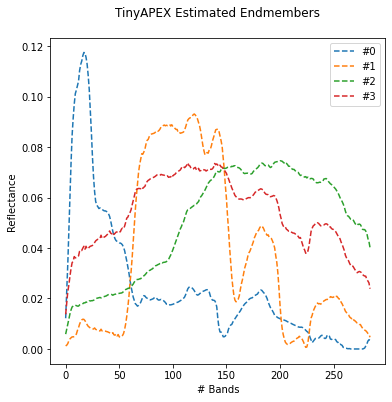

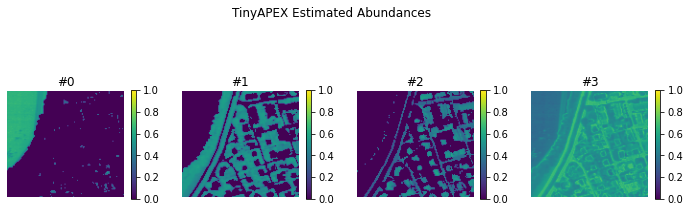

In [28]:
E0 = endmembers.T
A0 = abundances.T

# Plot results
hsi.plot_endmembers(E0=E0)
hsi.plot_abundances(A0=A0)

## Endmembers alignment

---

At this stage we need to align the endmembers and the abundances to compute the RMSE and SAD metrics.

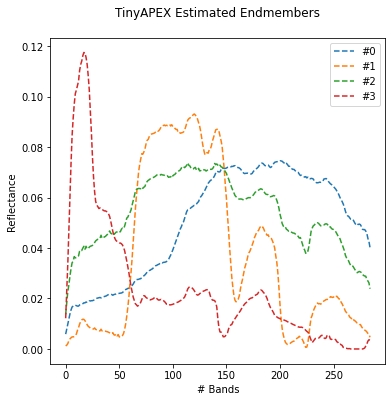

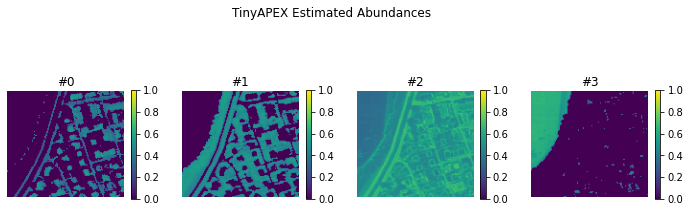

In [29]:
# Select a criterion to perform alignment
criterion = MSE()

# Select an aligner to perform alignment
aligner = Aligner(hsi=hsi, criterion=criterion)

A1 = aligner.fit_transform(A0)
E1 = aligner.transform_endmembers(E0)

# Plot alignment
hsi.plot_endmembers(E0=E1)
hsi.plot_abundances(A0=A1)

## Quantitative results

---

We are now in shape to compute the abundances RMSE and endmembers SAD.

In [30]:
# Instantiate metrics
rmse = RMSE()
sad = SADMetric()

# Compute final numbers
print(f"RMSE => {rmse(hsi.A, A1):.2f}")
print(f"SAD => {sad(hsi.E, E1):.2f}")

RMSE => 29.05
SAD => 15.49


### Results for each material

In [31]:
# Change the following line if you change dataset!
# Either comment out or describe each material name.
hsi.labels = ["Road", "Tree", "Roof", "Water"]
assert len(hsi.labels) == hsi.p

for ii, label in enumerate(hsi.labels):
    a, ahat = hsi.A[ii], A1[ii]
    print(f"RMSE ({label}) => {rmse(a, ahat):.2f}")

print("-" * 15)

for ii, label in enumerate(hsi.labels):
    e, ehat = hsi.E[:, ii][:, None], E1[:, ii][:, None]
    print(f"SAD ({label}) => {sad(e, ehat):.2f}")

RMSE (Road) => 22.76
RMSE (Tree) => 27.40
RMSE (Roof) => 39.68
RMSE (Water) => 23.09
---------------
SAD (Road) => 21.11
SAD (Tree) => 8.33
SAD (Roof) => 29.41
SAD (Water) => 3.12
